In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [3]:
pth = os.path.join('..', '..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'cancer')
pth_mod = os.path.join(pth_data, 'features', 'biomart', 'modules')
pth_out = os.path.join(pth, 'figures', 'cancer', 'CCCA')

In [4]:
name = 'Giustacchini2017'
adata = sc.read_h5ad(os.path.join(pth_in, f'{name}.h5ad'))
adata

AnnData object with n_obs × n_vars = 1964 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'viral', 'location', 'cancer_type', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores',

In [5]:
for mod in ('Early', 'Late'):
    print(mod)
    fn = os.path.join(pth_mod, f'{mod.lower()}.csv')
    g = pd.read_csv(fn).mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    sc.tl.score_genes(adata,
                      gene_list = g,
                      ctrl_as_ref = False,
                      score_name = mod,
                      random_state = 1234)

Early
Late


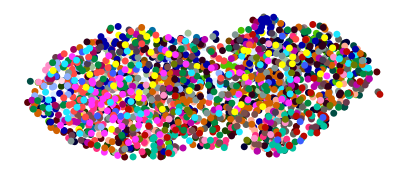

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (5, 2))
sc.pl.umap(adata, color = 'sample', size = 100,
           legend_loc = None, frameon = False,
           show = False, ax = ax)
ax.set_title('')
fn = os.path.join(pth_out, 'processed', f'{name}.pdf')
# plt.savefig(fn, bbox_inches = 'tight')

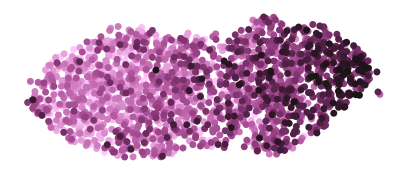

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (5, 2))
sc.pl.umap(adata, color = 'latent_z', size = 100,
           vmin = 0, vmax = 1, cmap = 'vanimo',
           colorbar_loc = None, frameon = False,
           show = False, ax = ax)
ax.set_title('')
fn = os.path.join(pth_out, 'trajectories', f'{name}.pdf')
# plt.savefig(fn, bbox_inches = 'tight')

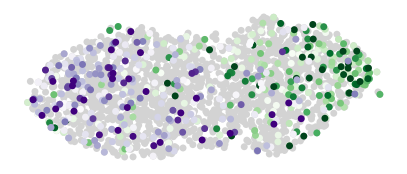

In [8]:
mod_plt = ['Late', 'Early']
vmin = {'Early' : -.025, 'Late' : .05}
vmax = {'Early' : 'p90', 'Late' : 'p90'}
cmap = {'Early' : 'Purples', 'Late' : 'Greens'}

fig, ax = plt.subplots(1, 1, figsize = (5, 2))
sc.pl.umap(adata, palette = 'lightgray', size = 100,
           frameon = False, show = False, ax = ax)
for mod in mod_plt:
    sc.pl.umap(adata[adata.obs[mod] > vmin[mod]],
               color = mod, size = 100, cmap = cmap[mod],
               vmin = vmin[mod], vmax = vmax[mod],
               colorbar_loc = None, frameon = False,
               show = False, ax = ax)
ax.set_title('')
fn = os.path.join(pth_out, 'modules', f'{name}.pdf')
# plt.savefig(fn, bbox_inches = 'tight')

In [19]:
X = pd.DataFrame(adata.X.toarray(), index = adata.obs_names, columns = adata.var_names)
umap1 = pd.DataFrame(adata.obsm['X_umap'][:, 0], index = adata.obs_names, columns = ['umap1'])
df = pd.concat((X, umap1), axis = 1)
R = df.corr().umap1.sort_values(ascending = False).drop('umap1').dropna()

In [20]:
R

Tuba1b    0.549103
Tpi1      0.548265
Nme1      0.509405
Aldoa     0.505135
Fabp5     0.482605
            ...   
Dpysl5   -0.132160
Sgcb     -0.143310
Sema3e   -0.165000
L1td1    -0.185511
Greb1    -0.202972
Name: umap1, Length: 811, dtype: float64

Early


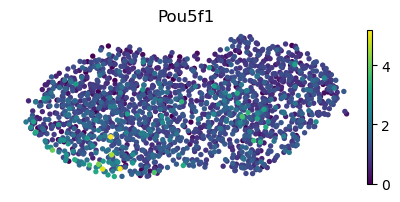

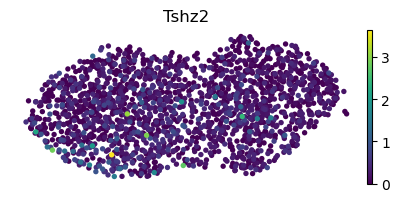

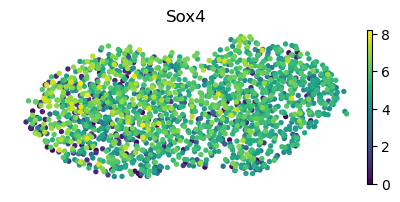

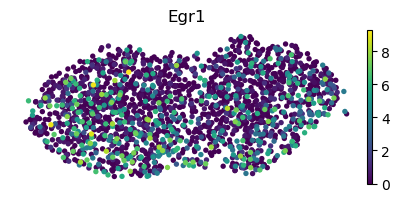

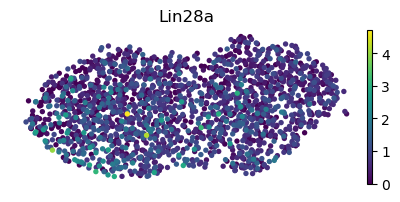

Late


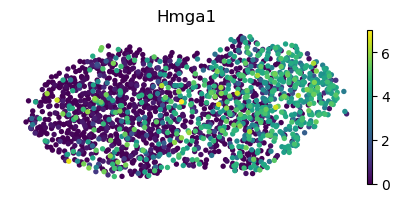

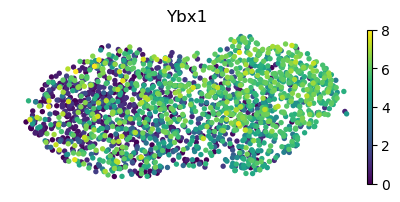

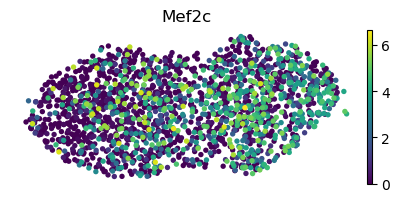

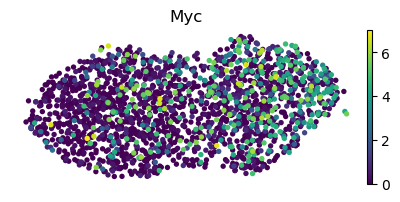

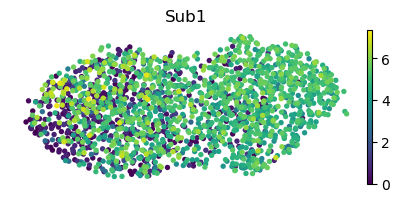

In [40]:
fn = os.path.join(pth_data, 'features', 'AnimalTFDB4', 'Mus_musculus_TF.txt')
tf = pd.read_csv(fn, sep = '\t').Symbol

adata.obs['stage'] = 'Late'
adata.obs.loc[adata.obsm['X_umap'][:, 0] < adata.obsm['X_umap'][:, 0].mean(), 'stage'] = 'Early'
# adata.obs.loc[adata.obsm['X_umap'][:, 0] < adata.obsm['X_umap'][:, 0].mean(), 'stage'] = 'Late'

sc.tl.rank_genes_groups(adata, 'stage',
                        groups = ['Early', 'Late'],
                        method = 'wilcoxon')

for mod in ('Early', 'Late'):
    print(mod)
    df = sc.get.rank_genes_groups_df(adata, mod)
    for g in df.loc[df.names.isin(tf)].head().names:
        fig, ax = plt.subplots(1, 1, figsize = (5, 2))
        sc.pl.umap(adata, color = g, size = 60,
                    frameon = False, ax = ax)
        plt.show()